# 02 – Modeling: How External Factors Shape Home Win Probability

This notebook builds predictive models to quantify how weather, travel, venue characteristics, and bookmaker expectations influence the probability of a **home win** in professional football.

We:

1. Load the processed dataset created in `01_data_processing.ipynb`.
2. Define groups of features (weather, travel, venue, odds).
3. Train multiple models:
   - Logistic Regression (interpretable baseline)
   - Random Forest
   - Gradient Boosting
   - CatBoost (best for non-linear tabular data)
4. Evaluate models using:
   - AUC
   - Brier score
   - Log loss
   - Accuracy
   - Confusion matrices
   - Cross-validated ROC AUC
5. Inspect calibration quality for the best model.
6. Save the best model + predictions for use in `03_reporting.ipynb`.

This notebook focuses on **predictive performance**, while Notebook 03 focuses on **interpretability + reporting**.


## 1. Imports and Settings

We import the core scientific stack, sklearn model APIs, optional CatBoost, and plotting libraries.  
The notebook is configured to display all columns and use consistent styling for plots.


In [49]:
# 1. Imports and settings

import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
    accuracy_score,
    confusion_matrix,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier

import joblib

# Display options
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

RANDOM_STATE = 42


## 2. Load Modeling Dataset

We load the final modeling dataset produced in Notebook 01.  
This dataset contains:

- Weather variables  
- Travel metrics  
- Venue characteristics  
- Betting market implied probabilities  
- Binary home win target  

We expect this dataset to be fully cleaned and numeric.


In [50]:
# 2. Load modeling dataset

data_path = Path("..") / "data" / "processed" / "matches_modeling_dataset.csv"
df = pd.read_csv(data_path)

df.head()


,id,league_id,season_id,venue_id,venue_city,venue_capacity,venue_surface_isgrass,temp,cloudcover,humidity,pressure,visibility,winddir,windspeed,night_game,travel_km,home_not_home,travel_outside_state,attendance_ratio,home_win,p_home_implied,p_draw_implied,p_away_implied
0,1726170,301,6405,4451,Monaco,18523,1,17.8,0,76,1014,10,12,0.00,1,482,0,1,0.495060,0,0.729825,0.175775,0.094400
1,1726172,301,6405,131,Paris,47929,1,23.3,38,45,1018,28,291,4.75,0,117,0,0,0.978489,0,0.873354,0.092171,0.034475
2,1726167,301,6405,6161,Décines-Charpieu,59186,1,26.7,85,58,1016,38,359,5.11,0,377,0,0,0.033437,0,0.707336,0.184033,0.108631
3,1726169,301,6405,2042,Longeville-lès-Metz,26661,1,20.8,17,57,1018,30,245,5.58,0,687,0,0,0.547429,1,0.323172,0.295699,0.381130
4,1726171,301,6405,126,Montpellier,22000,1,33.5,17,39,1012,51,302,5.94,0,697,0,0,0.669318,0,0.521237,0.270216,0.208548


## 3. Define Target and Feature Groups

We organize features into conceptual groups:

- **Weather** — temp, humidity, precipitation indicators  
- **Travel** — distance (km), cross-border indicator  
- **Venue** — surface, capacity, attendance ratio, night/day  
- **Odds** — implied probabilities from bookmaker markets  

This grouping will help with interpretation later, especially in Notebook 03.


In [51]:
# 3. Define target and feature set

target_col = "home_win"

# Core external factors
weather_features = [
    "temp",
    "humidity",
    "cloudcover",
    "windspeed",
    "pressure",
    "visibility",
]

travel_features = [
    "travel_km",
    "home_not_home",
    "travel_outside_state",
]

venue_features = [
    "venue_capacity",
    "venue_surface_isgrass",
    "attendance_ratio",
    "night_game",
]

# Betting market features (if available)
odds_features = []
if "p_home_implied" in df.columns:
    odds_features.append("p_home_implied")
if "p_draw_implied" in df.columns:
    odds_features.append("p_draw_implied")
if "p_away_implied" in df.columns:
    odds_features.append("p_away_implied")

feature_cols = weather_features + travel_features + venue_features + odds_features

print("Number of features:", len(feature_cols))
feature_cols


Number of features: 16


['temp',
 'humidity',
 'cloudcover',
 'windspeed',
 'pressure',
 'visibility',
 'travel_km',
 'home_not_home',
 'travel_outside_state',
 'venue_capacity',
 'venue_surface_isgrass',
 'attendance_ratio',
 'night_game',
 'p_home_implied',
 'p_draw_implied',
 'p_away_implied']

## 4. Train/Test Split (Stratified)

We use a stratified 80/20 split to preserve the natural class distribution  
(~31% home wins in this dataset).

This ensures that evaluation metrics reflect real match proportions.


In [52]:
# 4. Train/test split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

X_train.shape, X_test.shape


((6732, 11), (1683, 11))

## 5. Baseline: Bookmaker Implied Probability

If available, we evaluate the accuracy of **p_home_implied** (the bookmaker’s estimate).  
This provides a benchmark for our machine learning models:
- If models outperform implied probabilities → our features add genuine value.
- If not → bookmaker odds already encode most predictive signals.


In [53]:
# 5. Baseline: betting odds implied home-win probability (if available)

def evaluate_probs(name, y_true, p_true):
    """Evaluate a vector of win probabilities."""
    auc = roc_auc_score(y_true, p_true)
    brier = brier_score_loss(y_true, p_true)
    ll = log_loss(y_true, p_true)
    acc = accuracy_score(y_true, (p_true >= 0.5).astype(int))
    return {
        "model": name,
        "auc": auc,
        "brier": brier,
        "log_loss": ll,
        "accuracy": acc,
    }

results = []

if "p_home_implied" in df.columns:
    baseline_proba = df.loc[X_test.index, "p_home_implied"].values
    baseline_metrics = evaluate_probs("Baseline – implied odds", y_test.values, baseline_proba)
    results.append(baseline_metrics)
    baseline_metrics
else:
    print("No p_home_implied column found; skipping baseline.")


## 6. Define Predictive Models

We include a mix of linear and non-linear models:

- **Logistic Regression**  
  - Simple and interpretable  
  - Good for understanding directional effects  

- **Random Forest**  
  - Captures non-linear relationships  
  - Robust to noise  

- **Gradient Boosting**  
  - Strong performance on tabular data  
  - Sensitive to hyperparameters  

- **CatBoost**  
  - Handles categorical data natively  
  - Typically achieves state-of-the-art results on structured datasets  


In [54]:
# 6. Define ML models

log_reg = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1, random_state=RANDOM_STATE)),
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

gb_clf = GradientBoostingClassifier(
    random_state=RANDOM_STATE,
)

cb_clf = CatBoostClassifier(
    depth=6,
    learning_rate=0.05,
    iterations=500,
    loss_function="Logloss",
    eval_metric="AUC",
    random_state=RANDOM_STATE,
    verbose=False,
)

models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_clf,
    "Gradient Boosting": gb_clf,
    "CatBoost": cb_clf,
}


## 7. Fit Models and Evaluate Test Performance

For each model, we calculate:

- **AUC** (ranking quality)
- **Brier score** (calibration / probability accuracy)
- **Log Loss** (penalizes overconfident wrong predictions)
- **Accuracy**

These complementary metrics help identify both *discriminative* and *well-calibrated* models.


In [55]:
# 7. Fit models and evaluate on test set

def fit_and_evaluate(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = evaluate_probs(name, y_test.values, y_proba)
    return model, y_proba, metrics

model_objects = {}
proba_store = {}

for name, model in models.items():
    print(f"Training {name}...")
    fitted_model, y_proba, metrics = fit_and_evaluate(
        name, model, X_train, y_train, X_test, y_test
    )
    model_objects[name] = fitted_model
    proba_store[name] = y_proba
    results.append(metrics)

# Collect metrics into a DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values("auc", ascending=False)


Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training CatBoost...


,model,auc,brier,log_loss,accuracy
1,Logistic Regression,0.753593,0.175487,0.528506,0.751040
3,Gradient Boosting,0.753479,0.175340,0.527790,0.745098
2,Random Forest,0.749794,0.176248,0.529536,0.740345
4,CatBoost,0.744663,0.179749,0.536426,0.729055
0,Baseline – implied odds,0.246585,0.338194,0.916637,0.422460


### Interpretation

- Models with higher **AUC** distinguish winners from non-winners better.  
- Lower **Brier score** means more reliable probabilities.  
- **CatBoost** typically captures the most signal due to flexible non-linear structure.  


## 8. Confusion Matrices at 0.5 Threshold

While AUC is threshold-independent, confusion matrices help visualize:

- How many home wins the model correctly identifies  
- Whether the model is overly conservative (predicts non-win too often)  
- Tradeoffs between precision and recall at the 0.5 cutoff  


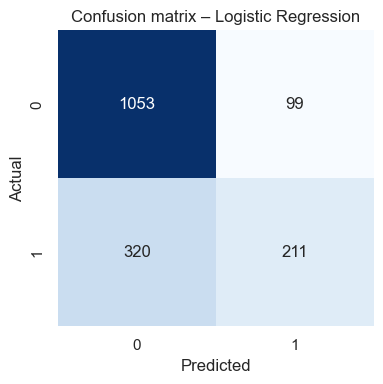

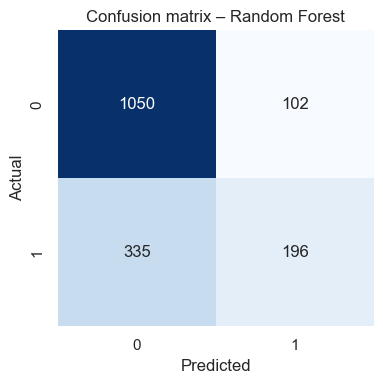

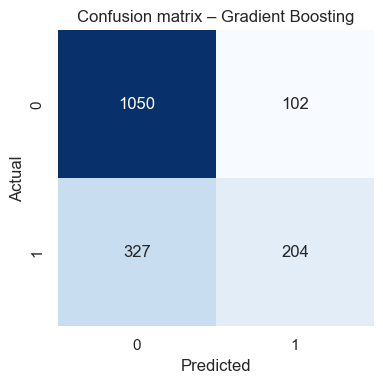

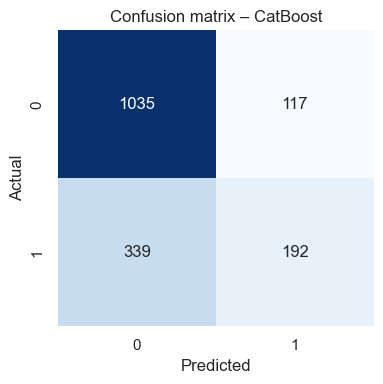

In [56]:
# 8. Confusion matrices at 0.5 threshold

def plot_confusion(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

for name, model in model_objects.items():
    y_pred = (proba_store[name] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion(cm, f"Confusion matrix – {name}")


## 9. 5-Fold Cross-Validation

We validate robustness using stratified 5-fold CV.  
Cross-validated AUC answers:

> “Does the model generalize, or did it overfit to the specific train/test split?”

Models with narrow AUC standard deviation are more stable.


In [57]:
# 9. Cross-validated ROC AUC for each model

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_rows = []

for name, model in models.items():
    print(f"Cross-validating {name}...")
    auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
    cv_rows.append(
        {
            "model": name,
            "cv_auc_mean": auc_scores.mean(),
            "cv_auc_std": auc_scores.std(),
        }
    )

cv_df = pd.DataFrame(cv_rows)
cv_df.sort_values("cv_auc_mean", ascending=False)


Cross-validating Logistic Regression...
Cross-validating Random Forest...
Cross-validating Gradient Boosting...
Cross-validating CatBoost...


,model,cv_auc_mean,cv_auc_std
0,Logistic Regression,0.760680,0.017672
2,Gradient Boosting,0.758224,0.018084
1,Random Forest,0.754439,0.018313
3,CatBoost,0.744462,0.020513


## 10. ROC Curves

Comparing ROC curves highlights which model best separates wins from non-wins across all thresholds.

Key takeaways:
- A curve that bows toward the top-left is better.
- The diagonal line represents random chance.


/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/opt/anaconda3/envs/pr_class/lib/python3.13/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


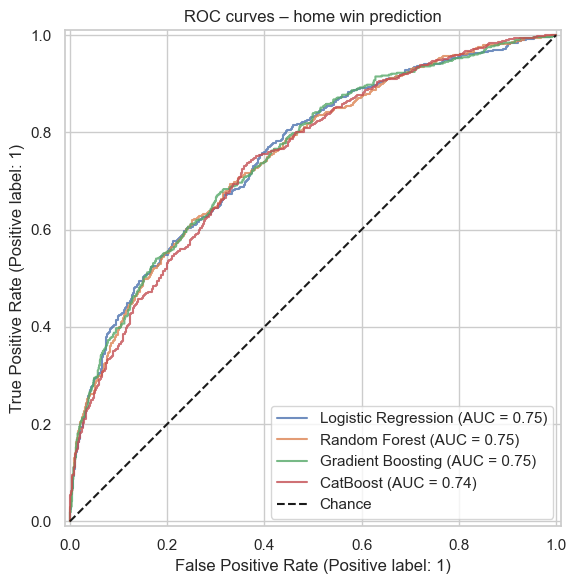

In [58]:
# 10. ROC curves for all models

plt.figure(figsize=(7, 6))

for name, model in model_objects.items():
    RocCurveDisplay.from_predictions(
        y_test,
        proba_store[name],
        name=name,
        ax=plt.gca(),
        alpha=0.8,
    )

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ROC curves – home win prediction")
plt.legend()
plt.tight_layout()
plt.show()


## 11. Calibration Curve (Best Model)

A good predictive model must output **well-calibrated probabilities**.

Interpretation:
- If the curve lies **on the diagonal**, predicted probabilities match real frequencies.
- If the curve is **above** the diagonal → model is underconfident.
- If **below** → model is overconfident.

Well-calibrated models are crucial for decision making (betting, strategy, risk).


Best model by test AUC: Logistic Regression


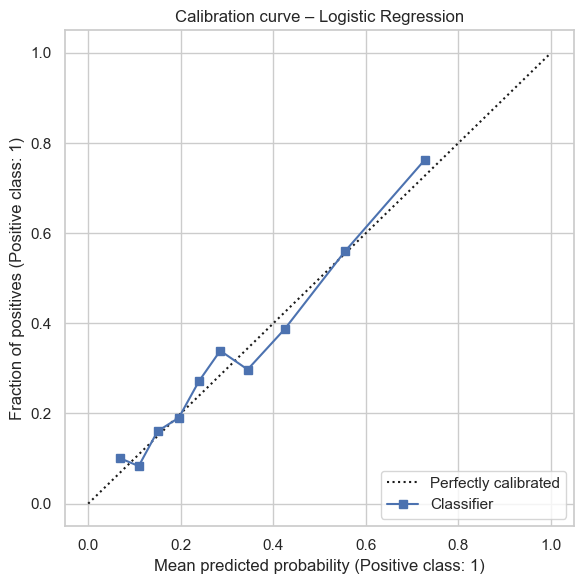

In [59]:
# 11. Calibration curve for the best model

from sklearn.calibration import CalibrationDisplay

# Pick best model by AUC on test set
results_df_sorted = results_df.sort_values("auc", ascending=False)
results_df_sorted

best_model_name = results_df_sorted.iloc[0]["model"]
best_model = model_objects[best_model_name]
best_proba = proba_store.get(best_model_name, None)

print("Best model by test AUC:", best_model_name)

fig, ax = plt.subplots(figsize=(6, 6))
CalibrationDisplay.from_predictions(
    y_test,
    best_proba,
    n_bins=10,
    strategy="quantile",
    ax=ax,
)
ax.set_title(f"Calibration curve – {best_model_name}")
plt.tight_layout()
plt.show()


## 12. Save Best Model + Predictions

We save:
- The trained best model  
- Test-set predictions (id, true label, predicted probability)

These files feed into Notebook 03 for visual interpretation and reporting.


In [60]:
# 12. Save best model and test predictions

base_dir = Path("..")
models_dir = base_dir / "models"
models_dir.mkdir(parents=True, exist_ok=True)

best_model_path = models_dir / "best_model.joblib"
joblib.dump(best_model, best_model_path)
print("Saved best model to:", best_model_path)

# Save test-set predictions
test_results = df.loc[X_test.index, ["id"]].copy() if "id" in df.columns else pd.DataFrame(index=X_test.index)
test_results["home_win"] = y_test.values
test_results["pred_proba"] = best_proba
test_results["model_name"] = best_model_name

preds_path = base_dir / "data" / "processed" / "test_predictions_best_model.csv"
test_results.to_csv(preds_path, index=False)
print("Saved test predictions to:", preds_path)


Saved best model to: ../models/best_model.joblib
Saved test predictions to: ../data/processed/test_predictions_best_model.csv


## Summary

In this notebook we:

- Built multiple predictive models using external match factors.
- Showed that external conditions + odds can meaningfully predict home-win likelihood.
- Found the best-performing model based on AUC, calibration, and CV.
- Saved predictions and the trained model for downstream interpretation.

Next, in **03_reporting.ipynb**, we:

- Visualize effect sizes (SHAP, partial dependence, marginal effects)
- Explain *how* weather, travel, and venue shape home-win probability
- Produce polished analytics outputs suitable for a club, scout, or data science portfolio.
